In [1]:
import torch
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
from torchvision.transforms.functional import rotate
from scipy.linalg import lstsq, null_space

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [2]:
def rot_mat(d): # questa è G
    mat = np.zeros(d**4).reshape(d**2,d**2)
    for j in range(d):
        for i in range(d):
            k = (i+1)*d-j
            h = i+(j)*d+1
#             print(h,k)
            mat[h-1][k-1] = 1
    return mat

def id_minus(mat): # questa è I - G
    d = len(mat)
    iden = np.identity(d)
    
    return (iden - mat)

def mat_sum(mat,s_d = 4):
    n = len(mat)
    out = np.zeros(n**2).reshape(n,n)
    for j in range(s_d):
        out = out + np.linalg.matrix_power(mat, j)
    return out

def W(output_dim, d = 4):
    kernel = null_space(id_minus(rot_mat(d)).T).T
    W = []
    for j in range(output_dim):
        vec = np.zeros(d**2)
        for k in kernel:
            vec = np.random.random()*k + vec
        W.append(list(vec))
    W = np.array(W)/len(kernel)
    return np.array(W)

def W_old(output_dim, mat, s_d=4):
    n = len(mat)
    positions = mat_sum(mat,s_d = 4)
    
    W = []
    for k in range(output_dim):
        vec = np.zeros(n)
        for j in positions[0:n//2+1]:
            vec = j*np.random.random()/(n/2) + vec
        W.append(list(vec))
        
    return np.array(W)

In [3]:
def project_grad(loss, rotated_loss, model):
    
    optimizer.zero_grad()  
    loss.backward(retain_graph=True)  

    grads1 = {name: param.grad.clone() for name, param in model.named_parameters()}

    optimizer.zero_grad()
    rotated_loss.backward(retain_graph=True)
    grads2 = {name: param.grad.clone() for name, param in model.named_parameters()}

    scalars = []
    norms = []
    with torch.no_grad():
        for name, param in model.named_parameters():
            if param.grad is not None:
                scalars.append(torch.dot(torch.flatten(grads1[name]), torch.flatten(grads2[name])))
                norms.append(torch.norm(grads2[name]**2))

    scalar = torch.sum(torch.Tensor(scalars))
    norm = torch.sum(torch.Tensor(norms))
    proj = scalar/norm

    with torch.no_grad():
        for name, param in model.named_parameters():
            if param.grad is not None:
                param.grad = grads1[name] - proj*grads2[name]



## Load Data

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


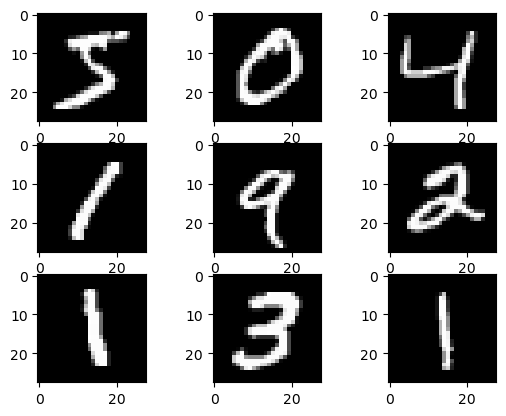

In [4]:
# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# plot first few images
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
# show the figure
plt.show()

## Define NN

In [47]:
from torch import nn

# Get cpu or gpu device for training.
device = "cpu"
print(f"Using {device} device")

class InvariantNN(nn.Module):
    def __init__(self):
        super(InvariantNN, self).__init__()
        
        self.softmax = nn.Softmax()
        
        self.flatten = nn.Flatten(start_dim=1)
        self.l1 = nn.Linear(28*28, 64)
        self.l2 = nn.Linear(64, 64)
        self.l3 = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        
        self.loss = nn.CrossEntropyLoss()
        
    def default_gradient(self, x0, target):
        optimizer.zero_grad()
        loss = self.loss(self.forward(x0), target)
        loss.backward(retain_graph=True)  
        grads1 = {name: param.grad.clone() for name, param in self.named_parameters()}
        flatten_gradient1 = torch.concatenate([grad.flatten() for grad in grads1.values()])
        return grads1, flatten_gradient1
    
    def invariance_gradient(self, x0, x0_r, target):
        optimizer.zero_grad()
        invariance_loss = self.loss(self.forward(x0), target) - self.loss(self.forward(x0_r), target)
        invariance_loss.backward(retain_graph=True)
        grads2 = {name: param.grad.clone() for name, param in self.named_parameters()}
        flatten_gradient2 = torch.concatenate([grad.flatten() for grad in grads2.values()])
        return grads2, flatten_gradient2

    def project_gradient(self, scalar, norm, grads1, grads2):
        
        with torch.no_grad():
            for name, param in self.named_parameters():
                if param.grad is not None:
                    param.grad = grads1[name] - (scalar/(norm**2))*grads2[name]
        return {name: param.grad.clone() for name, param in self.named_parameters()}


    def forward(self, x):
        x = self.flatten(x)
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)    
        x = self.relu(x)
        x = self.l3(x)
        x = self.relu(x)
#         x = self.softmax(x)
        return  x
    
    
# print(model)

Using cpu device


In [57]:
model = InvariantNN()
model.l1.weight.data = torch.Tensor(W(64,d = 28))
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5, momentum=0)

x0 = torch.Tensor(trainX)
y0 = torch.Tensor(trainy)

rotated_data_90 = rotate(img = x0, angle = 90)

pred1 = model(x0)
pred2 = model(rotated_data_90)

grads1, flat_grad1 = model.default_gradient(x0, y0.long())
grads2, flat_grad2 = model.invariance_gradient(x0, rotated_data_90, y0.long())

scalar = torch.dot(flat_grad1, flat_grad2)
norm = torch.norm(flat_grad2)

projected_gradient = model.project_gradient(scalar, norm, grads1, grads2)
projected_gradient_flat = torch.concatenate([grad.flatten() for grad in projected_gradient.values()])

In [59]:
torch.norm(projected_gradient_flat)

tensor(17.4252)

In [63]:
torch.dot(projected_gradient_flat, flat_grad2)/(torch.norm(projected_gradient_flat)* torch.norm(flat_grad2))

tensor(-1.4301e-06)

## Gradient projection train

In [27]:
model = InvariantNN()
model.l1.weight.data = torch.Tensor(W(64,d = 28))
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5, momentum=0)

x0 = torch.Tensor(trainX)
y0 = torch.Tensor(trainy)

rotated_data_90 = rotate(img = x0, angle = 90)
rotated_data_180 = rotate(img = x0, angle = 180)
rotated_data_270 = rotate(img = x0, angle = 270)
loss_history = []
accuracy = []
invariance = []

for i in range(100):
    l_inv = 0
    l_acc = 1
    
    
    pred1 = model(x0)
    pred2 = model(rotated_data_90)
    pred3 = model(rotated_data_180)
    pred4 = model(rotated_data_270)
    
    pred_vec = [pred2,pred3,pred4]
    
    _, arg1 = torch.max(pred1,1)
    _, arg2 = torch.max(pred2,1)
    _, arg3 = torch.max(pred3,1)
    _, arg4 = torch.max(pred4,1)
    
    
    acc = (arg1 == y0.long()).sum().item()/len(x0)
    inv_1 = (arg1 == arg2).sum().item()/len(x0)
    inv_2 = (arg1 == arg2).sum().item()/len(x0)
    inv_3 = (arg1 == arg3).sum().item()/len(x0)
    
    inv = (inv_1 +inv_2 + inv_3)/3
    
    loss = l_acc*loss_CE(pred1, y0.long())
#     pred_random = pred_vec[np.random.randint(3)]
    rotated_loss = loss_CE(pred2, y0.long()) - loss_CE(pred1, y0.long())

    
    
#     print(i)

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    size1 = model.l1.weight.grad.size()
    flat_gradient1 = model.l1.weight.grad.resize(size1[0]*size1[1])
    
    size2 = model.l2.weight.grad.size()
    flat_gradient2 = model.l2.weight.grad.resize(size2[0]*size2[1])
    
    size3 = model.l3.weight.grad.size()
    flat_gradient3 = model.l3.weight.grad.resize(size3[0]*size3[1])
    
    flat_gradientb1 = model.l1.bias.grad
    flat_gradientb2 = model.l2.bias.grad
    flat_gradientb3 = model.l3.bias.grad
    
    with torch.no_grad():
        optimizer.zero_grad()
        rotated_loss.backward(retain_graph=True)
        flat_gradient_rot1 = model.l1.weight.grad.resize(size1[0]*size1[1])
        flat_gradient_rot2 = model.l2.weight.grad.resize(size2[0]*size2[1])
        flat_gradient_rot3 = model.l3.weight.grad.resize(size3[0]*size3[1])
        flat_gradient_rotb1 = model.l1.bias.grad
        flat_gradient_rotb2 = model.l2.bias.grad
        flat_gradient_rotb3 = model.l3.bias.grad

        scalar_prod = torch.dot(flat_gradient1, flat_gradient_rot1) + torch.dot(flat_gradient2, flat_gradient_rot2) + torch.dot(flat_gradient3, flat_gradient_rot3)+ torch.dot(flat_gradientb3, flat_gradient_rotb3) + torch.dot(flat_gradientb2, flat_gradient_rotb2) + torch.dot(flat_gradientb1, flat_gradient_rotb1)

        gradient_norm = torch.norm(flat_gradient_rot1)**2 + torch.norm(flat_gradient_rot2)**2 + torch.norm(flat_gradient_rot3)**2+ torch.norm(flat_gradient_rotb3)**2 +  torch.norm(flat_gradient_rotb2)**2 + torch.norm(flat_gradient_rotb1)**2

        my_grad1 = flat_gradient1 - scalar_prod*flat_gradient_rot1 / gradient_norm
        my_grad2 = flat_gradient2 - scalar_prod*flat_gradient_rot2 / gradient_norm
        my_grad3 = flat_gradient3 - scalar_prod*flat_gradient_rot3 / gradient_norm
        my_gradb1 = flat_gradientb1 - scalar_prod*flat_gradient_rotb1 / gradient_norm
        my_gradb2 = flat_gradientb2 - scalar_prod*flat_gradient_rotb2 / gradient_norm
        my_gradb3 = flat_gradientb3 - scalar_prod*flat_gradient_rotb3 / gradient_norm


        my_grad1 = my_grad1.resize(size1[0], size1[1])
        my_grad2 = my_grad2.resize(size2[0], size2[1])
        my_grad3 = my_grad3.resize(size3[0], size3[1])

        model.l1.weight.grad = my_grad1
        model.l2.weight.grad = my_grad2
        model.l3.weight.grad = my_grad3
        model.l1.bias.grad = my_gradb1
        model.l2.bias.grad = my_gradb2
        model.l3.bias.grad = my_gradb3
    
    if (i%20 == 1) or (i ==0):
        print("Accuracy: " , round(acc, 2))
        print("Invariance: ", round(inv, 2))
        print("Loss: " , loss.detach().numpy())
          
    loss_history.append(loss.detach().numpy())
    accuracy.append(acc)
    invariance.append(inv)
    
#     loss.backward()
    optimizer.step()

C:\Users\scanu\anaconda3\envs\geo\lib\site-packages\torch\_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Accuracy:  0.09
Invariance:  1.0
Loss:  2.4054873
Accuracy:  0.09
Invariance:  1.0
Loss:  2.3936875
Accuracy:  0.12
Invariance:  0.94
Loss:  2.2988288
Accuracy:  0.18
Invariance:  0.84
Loss:  2.2615964
Accuracy:  0.23
Invariance:  0.78
Loss:  2.2294984
Accuracy:  0.27
Invariance:  0.74
Loss:  2.1953154


In [64]:
model = InvariantNN()
model.l1.weight.data = torch.Tensor(W(64,d = 28))
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5, momentum=0)

x0 = torch.Tensor(trainX)
y0 = torch.Tensor(trainy)

rotated_data_90 = rotate(img = x0, angle = 90)
rotated_data_180 = rotate(img = x0, angle = 180)
rotated_data_270 = rotate(img = x0, angle = 270)
loss_history = []
accuracy = []
invariance = []
loss_r = []

for i in range(100):
    l_inv = 0
    l_acc = 1
    
    
    pred1 = model(x0)
    pred2 = model(rotated_data_90)
    pred3 = model(rotated_data_180)
    pred4 = model(rotated_data_270)
    
    pred_vec = [pred2,pred3,pred4]
    
    _, arg1 = torch.max(pred1,1)
    _, arg2 = torch.max(pred2,1)
    _, arg3 = torch.max(pred3,1)
    _, arg4 = torch.max(pred4,1)
    
    
    acc = (arg1 == y0.long()).sum().item()/len(x0)
    inv_1 = (arg1 == arg2).sum().item()/len(x0)
    inv_2 = (arg1 == arg2).sum().item()/len(x0)
    inv_3 = (arg1 == arg3).sum().item()/len(x0)
    
    inv = (inv_1 +inv_2 + inv_3)/3
    
    loss = l_acc*loss_CE(pred1, y0.long())
    rotated_loss = loss_CE(pred2, y0.long()) - loss_CE(pred1, y0.long())

    grads1, flat_grad1 = model.default_gradient(x0, y0.long())
    grads2, flat_grad2 = model.invariance_gradient(x0, rotated_data_90, y0.long())

    scalar = torch.dot(flat_grad1, flat_grad2)
    norm = torch.norm(flat_grad2)

    projected_gradient = model.project_gradient(scalar, norm, grads1, grads2)
    
    if (i%20 == 1) or (i ==0):
        print("Accuracy: " , round(acc, 2))
        print("Invariance: ", round(inv, 2))
        print("Loss: " , loss.detach().numpy())
          
    loss_history.append(loss.detach().numpy())
    loss_r.append(rotated_loss.detach().numpy())
    accuracy.append(acc)
    invariance.append(inv)
    
#     loss.backward()
    optimizer.step()

Accuracy:  0.09
Invariance:  1.0
Loss:  2.3280578
Accuracy:  0.09
Invariance:  1.0
Loss:  2.3261454
Accuracy:  0.14
Invariance:  0.94
Loss:  2.2894833
Accuracy:  0.21
Invariance:  0.88
Loss:  2.2525406
Accuracy:  0.29
Invariance:  0.82
Loss:  2.2017715
Accuracy:  0.32
Invariance:  0.78
Loss:  2.1402266


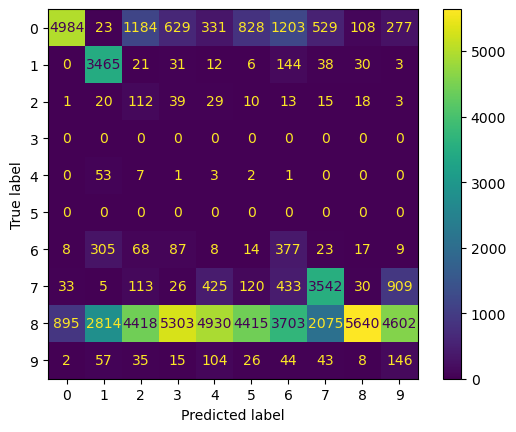

In [9]:
cm = confusion_matrix(arg1, y0.long())
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

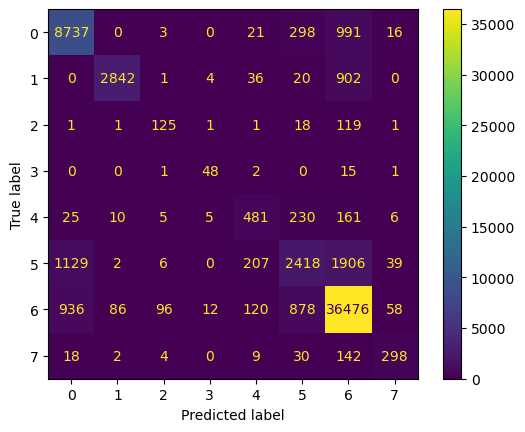

In [11]:
rotated_data = rotate(img = x0, angle = 180)

pred1 = model(x0)
pred2 = model(rotated_data)
_, arg1 = torch.max(pred1,1)
_, arg2 = torch.max(pred2,1)

cm = confusion_matrix(arg1, arg2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

C:\Users\scanu\AppData\Local\Temp\ipykernel_11180\199208642.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
C:\Users\scanu\AppData\Local\Temp\ipykernel_11180\199208642.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  g.show()


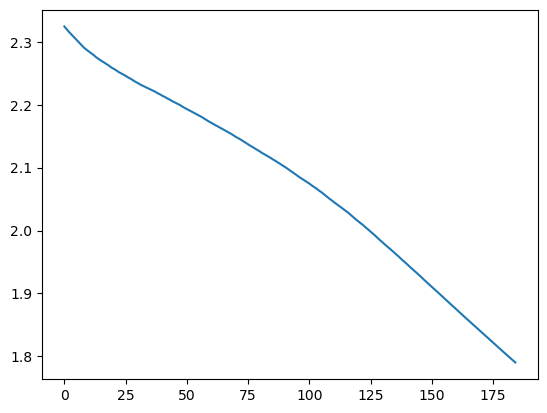

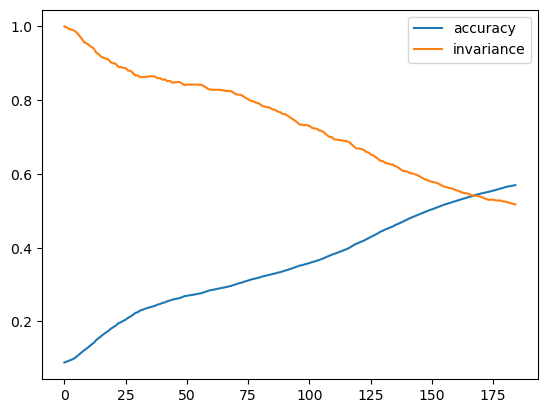

In [40]:
f = plt.figure(1)
plt.plot(loss_history)
f.show()
g = plt.figure(2)
plt.plot(accuracy, label = "accuracy")
plt.plot(invariance, label = "invariance")
plt.legend()
g.show()



Due obiettivi:
* siamo entrati nella manifold (nessuno si è accorto di noi)
* 

## Root finding

In [238]:
from scipy import optimize

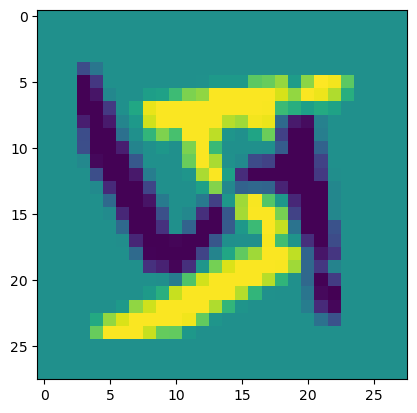

In [5]:
plt.imshow((x0[0] - rotate(img = x0, angle = 270))[0])

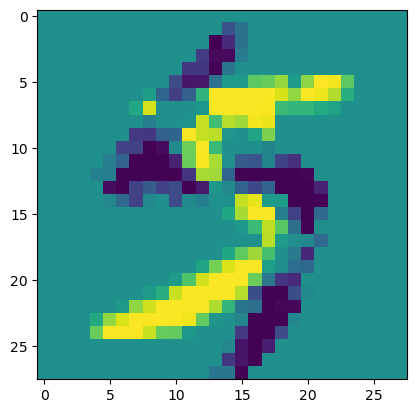

In [29]:
plt.imshow((x0[0] - rotate(img = x0, angle = 45))[0])

In [ ]:
scipy.linalg.
lstsq
scipy.linalg.lstsq

In [29]:
# Definisci la matrice A
A = np.array([[2, 4], [1, 2]])

# Calcola il kernel
kernel = null_space(A)
print("Kernel della matrice:")
print(kernel.flatten())


Kernel della matrice:
[-0.89442719  0.4472136 ]


In [81]:
Weights = W(5,rot_mat(28))

In [82]:
image1 = model.flatten(x0[0:1]).detach().numpy()[0]
image1_rot = model.flatten(rotate(img = x0[0:1], angle = 90)).detach().numpy()[0]

In [83]:
out1 = Weights@image1
out2 = Weights@image1_rot

In [84]:
out1

array([858675., 844117., 863484., 805784., 751304.])

In [86]:
out2

array([858675., 844117., 863484., 805784., 751304.])

In [85]:
out1-out2

array([0., 0., 0., 0., 0.])

In [15]:
x_vec = x.reshape(16)
x_r = mat@x_vec
x_r_img = x_r.reshape(4,4)
plt.imshow(x_r_img)

NameError: name 'mat' is not defined

## Train

# Standard train

In [18]:
model = InvariantNN()
# model.l1.weight.data = torch.Tensor(W(64,rot_mat(28)))
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

x0 = torch.Tensor(trainX)
y0 = torch.Tensor(trainy)

rotated_data = rotate(img = x0, angle = 110)
loss_history = []
accuracy = []

for i in range(400):
    l_inv = 0
    l_acc = 1
    optimizer.zero_grad()
    
    pred1 = model(x0)
    pred2 = model(rotated_data)
    avg_pred = torch.sum(pred1, axis = 0)/6000
    
    _, arg1 = torch.max(pred1,1)
    _, arg2 = torch.max(pred2,1)
    
    
    acc = (arg1 == y0.long()).sum().item()/len(x0)
    inv = (arg1 == arg2).sum().item()/len(x0)   
    
    loss = loss_CE(pred1, y0.long()) #- 0.001*loss_CE( avg_pred , uniform_dist )
    
    
    if i%5 == 1:
        print("Accuracy: " , round(acc, 2))
        print("Invariance: ", round(inv, 2))
        print("Loss: " , loss.detach().numpy())
          
    loss_history.append(loss.detach().numpy())
    accuracy.append(acc)
    
    loss.backward()
    optimizer.step()

Accuracy:  0.11
Invariance:  0.4
Loss:  9.002374
Accuracy:  0.1
Invariance:  0.16
Loss:  4.0445075
Accuracy:  0.1
Invariance:  0.1
Loss:  2.7000878
Accuracy:  0.13
Invariance:  0.13
Loss:  2.363183
Accuracy:  0.16
Invariance:  0.2
Loss:  2.2700348
Accuracy:  0.18
Invariance:  0.27
Loss:  2.2112734
Accuracy:  0.2
Invariance:  0.34
Loss:  2.1408384
Accuracy:  0.22
Invariance:  0.39
Loss:  2.081108
Accuracy:  0.24
Invariance:  0.39
Loss:  2.0376077
Accuracy:  0.26
Invariance:  0.35
Loss:  1.986369
Accuracy:  0.29
Invariance:  0.3
Loss:  1.9362472
Accuracy:  0.3
Invariance:  0.28
Loss:  1.896615
Accuracy:  0.31
Invariance:  0.29
Loss:  1.8545204
Accuracy:  0.32
Invariance:  0.31
Loss:  1.8167752
Accuracy:  0.33
Invariance:  0.32
Loss:  1.7863309
Accuracy:  0.34
Invariance:  0.32
Loss:  1.7606807
Accuracy:  0.34
Invariance:  0.31
Loss:  1.7393464
Accuracy:  0.35
Invariance:  0.31
Loss:  1.7207524
Accuracy:  0.36
Invariance:  0.3
Loss:  1.7038072
Accuracy:  0.36
Invariance:  0.3
Loss:  1.687

Accuracy:  0.12263
Invariance:  1.0
Loss:  5.6825933


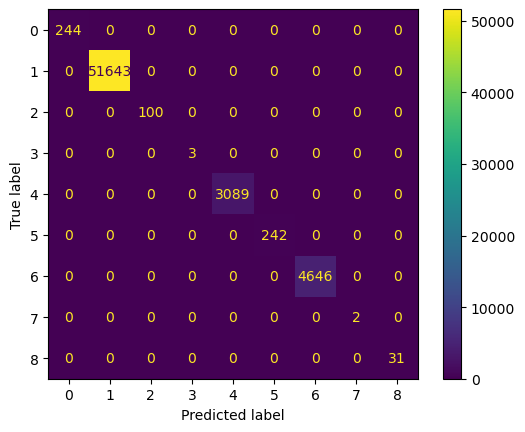

In [38]:
model = InvariantNN()
model.l1.weight.data = torch.Tensor(W(64,28))

x0 = torch.Tensor(trainX)
y0 = torch.Tensor(trainy)

rotated_data = rotate(img = x0, angle = 270)

pred1 = model(x0)
pred2 = model(rotated_data)
avg_pred = torch.sum(pred1, axis = 0)/6000

_, arg1 = torch.max(pred1,1)
_, arg2 = torch.max(pred2,1)

acc = (arg1 == y0.long()).sum().item()/len(x0)
inv = (arg1 == arg2).sum().item()/len(x0) 
loss = loss_CE(pred1, pred2) + loss_CE(pred1, y0.long()) #- 0.001*loss_CE( avg_pred , uniform_dist )

print("Accuracy: " , round(acc, 5))
print("Invariance: ", round(inv, 9))
print("Loss: " , loss.detach().numpy())

cm = confusion_matrix(arg1, arg2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Definizione di una rete neurale di esempio
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.linear1 = nn.Linear(10, 5)
        self.linear2 = nn.Linear(5, 1)
    
    def forward(self, x):
        x = torch.relu(self.linear1(x))
        return self.linear2(x)

# Funzione per concatenare i gradienti di tutti i parametri in un unico vettore
def get_concatenated_gradients(grad_dict):
    return torch.cat([g.flatten() for g in grad_dict.values() if g is not None])

# Funzione per ricostruire i gradienti dai vettori concatenati
def set_gradients_from_vector(model, grad_vector, grad_dict):
    offset = 0
    for name, param in model.named_parameters():
        if grad_dict[name] is not None:
            grad_shape = grad_dict[name].shape
            grad_size = grad_dict[name].numel()
            param.grad = grad_vector[offset:offset + grad_size].view(grad_shape)
            offset += grad_size

# Inizializziamo il modello e l'ottimizzatore
model = SimpleNN()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Creiamo due insiemi di input differenti
x1 = torch.randn(3, 10)
x2 = torch.randn(3, 10)

# Creiamo dei target casuali per calcolare la loss
target1 = torch.randn(3, 1)
target2 = torch.randn(3, 1)

# STEP 1: Calcolo dei gradienti rispetto ai pesi per il primo input `x1`
output1 = model(x1)
loss1 = nn.functional.mse_loss(output1, target1)
optimizer.zero_grad()
loss1.backward(retain_graph=True)
grads1 = {name: param.grad.clone() for name, param in model.named_parameters()}

# STEP 2: Calcolo dei gradienti rispetto ai pesi per il secondo input `x2`
output2 = model(x2)
loss2 = nn.functional.mse_loss(output2, target2)
optimizer.zero_grad()
loss2.backward()
grads2 = {name: param.grad.clone() for name, param in model.named_parameters()}

# Concateniamo i gradienti in un unico vettore
grad1_vec = get_concatenated_gradients(grads1)
grad2_vec = get_concatenated_gradients(grads2)

# STEP 3: Calcolo della componente ortogonale di `grad1_vec` rispetto a `grad2_vec`
with torch.no_grad():
    dot_product = torch.dot(grad1_vec, grad2_vec)
    norm_grad2_sq = torch.norm(grad2_vec) ** 2

    # Evitiamo la divisione per zero
    if norm_grad2_sq > 0:
        # Calcoliamo la proiezione di `grad1_vec` su `grad2_vec`
        projection = (dot_product / norm_grad2_sq) * grad2_vec
        # Calcoliamo la componente ortogonale
        ortho_component = grad1_vec - projection
    else:
        ortho_component = grad1_vec

    # Ricostruiamo i gradienti nel modello usando la componente ortogonale
    set_gradients_from_vector(model, ortho_component, grads1)

# STEP 4: Eseguiamo l'aggiornamento dei pesi usando la componente ortogonale
optimizer.step()

# Stampa dei pesi aggiornati (opzionale)
print("Pesi aggiornati:")
for name, param in model.named_parameters():
    print(f"{name}: {param.data}")
